# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Machine Learning Solution for Machine Vision Task

### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Project Group 3

<style>
th {
    text-align: left;
}
</style>

|  Name | Student No.  |
|:---|:---|
| Reece Perrott  | 17007538  |
|  Lokesh Krishnasamy | 22052820   |
|  Waleed Niaz | 22053867  |

---
### Import all the necessary libraries

In [1]:
import copy
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental.preprocessing import *
%matplotlib inline
%pip install -q -U keras-tuner
from keras_tuner import RandomSearch
from keras_tuner import HyperParameter
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.0 MB/s eta 0:00:00


### Configuration

In [ ]:
# Sets a random seed for TensorFlow

tf.random.set_seed(0)

# Defines parameters for the dataset

DATASET = 'rock_paper_scissors'
TRAIN_TEST = 0.7
IMG_DIM = 256
N = 50 #Number of Epochs


---

## Image Classification for 'Rock, Paper, Scissors' Dataset



### Exploratory Data Analysis (EDA)

Once the dataset has been loaded, it is first split in to a training and test set, at the specified ratio (80%). From the training set an additional 20% of the data is then split into a validation set. A small sample of the images from the training set are then displayed to ensure the dataset has been loaded successfully. 

After splitting, some simple analysis of the data is provided to identfy any potential issues that may occur when attempting to train a model. Initial analysis of the data shows a lack of diversity of the images within the data. This may indicate a lack of useful training data and therefore increase the possibility that the model will overfit the data during training. As such the use of data augmentation should be implemented to attempt to increase the amount of training data and mitigate this issue.

In [ ]:
# Defines a function to load the specified dataset and splits it into train and test sets
def read_data(ds, split=0.8):
    """Loads the specified data set & return a train/test set"""
    
    ((X_train, y_train), (X_test, y_test)), info = tfds.load(ds,
        split=[f"train[:{int(split * 100)}%]", f"train[:{100 - int(split * 100)}%]"],
        batch_size=-1,
        as_supervised=True,
        with_info=True,   
    )

    return ((X_train, y_train), (X_test, y_test)), info


In [ ]:
# Loads the train and test dataset

((X_train, y_train), (X_test, y_test)), info = read_data(DATASET, TRAIN_TEST)

# Gets list of image classes

classes = info.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteQ9O11W/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteQ9O11W/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


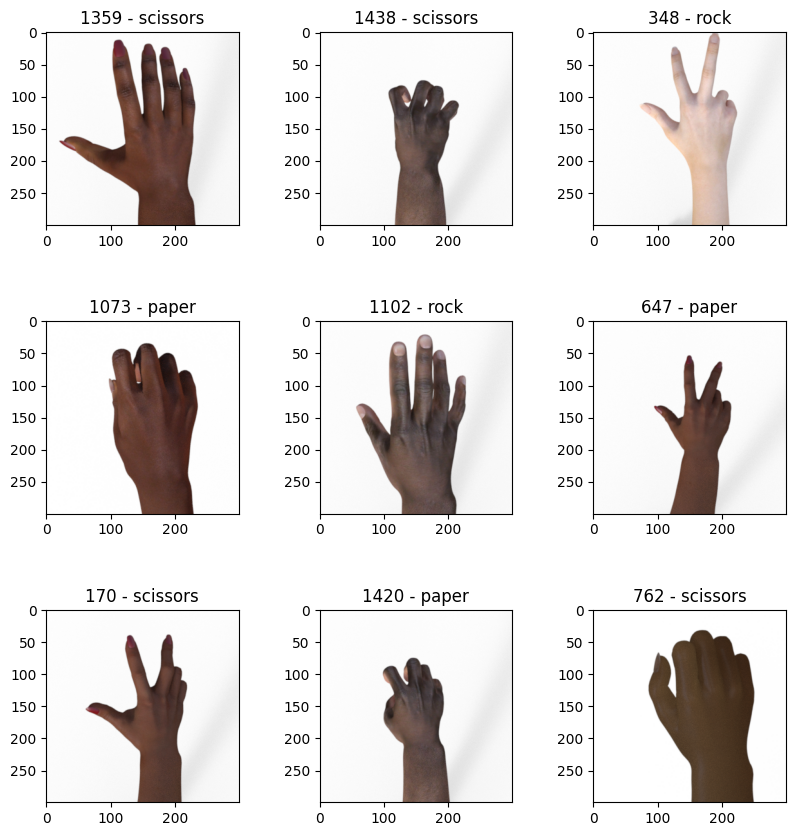

In [ ]:
# Checks the data set has been loaded correctly - loads a sample of images from the training set

n = np.random.randint(len(X_train), size=9)
labels = y_train.numpy()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[n[i]])
    plt.title(f'{n[i]} - {classes[labels[i]]}')
              
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Checks the number of images in each set

print(f'No. Training Images: {X_train.shape[0]}')
print(f'No. Test Images: {X_test.shape[0]}')

# Gets the image dimensions

print(f'Image Dim: {X_train[0].shape}')


No. Training Images: 1764
No. Test Images: 756
Image Dim: (300, 300, 3)


The balance of classes in the training set is also compared to ensure that there is no imbalance towards a specific class in the training data, as this could affect the amount information the model is able to learn for the remaining classes. Plotting the number of images for each class in the training and test sets shows an equal distribution.

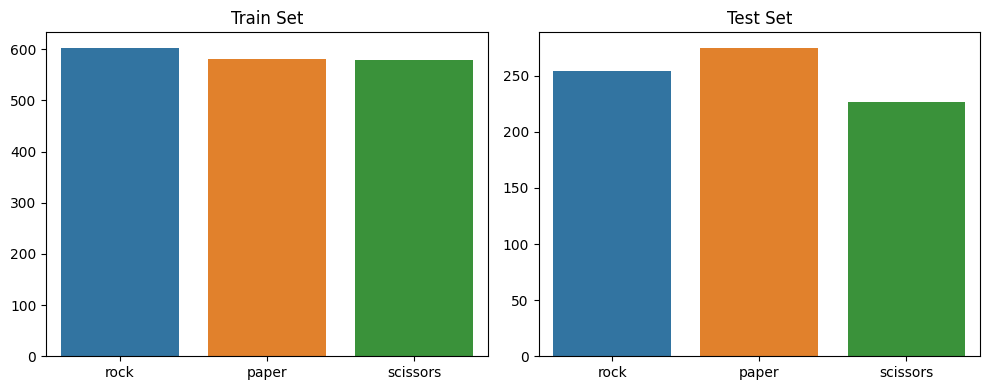

In [ ]:
# Plots bar charts to visualise the count of each class in the train and test sets

train_count = np.unique(y_train, return_counts=True)[1]
test_count = np.unique(y_test, return_counts=True)[1]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=classes, y=train_count, ax=ax[0])
ax[0].set_xticklabels(classes)
ax[0].set_title('Train Set')
sns.barplot(x=classes, y=test_count, ax=ax[1])
ax[1].set_xticklabels(classes)
ax[1].set_title('Test Set')
plt.tight_layout()
plt.show()



A pre-processing pipeline is defined to ensure that the image is scaled and at the correct dimensions for the input to the CNN. An additional step is also to provided to allow for data augmentation to be applied to the images during training.

In [ ]:
# Defines pre-processing pipeline:-
# Rescaling normalises pixel values within range [0, 1]. To set range [-1, 1] use tf.keras.layers.Rescaling(1./127.5, offset=-1)

preprocessing_Pipeline = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Resizing(IMG_DIM, IMG_DIM)
], name='pre-processing')


In [ ]:
# Defines a data augmentation pipeline using Keras Sequential model

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation((-0.25, 0.25)),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.3)
], name='augmentation')

---
## Image Classification

## Simple CNN

This defines a simple CNN model to provide a baseline in the performance of classification for the dataset. The CNN consits of 3 convolutional layers with max pooling between each layer, ending with a fully connected layer before a final output layer which predicts the image class.

From this benchmark further changes/tuning to the architecure and hyper-parameters of the model can then be applied to further improve the accuracy/efficiency of the model in classifying the data.


In [ ]:
# Defines a Sequential Model using Keras

model = tf.keras.Sequential([
    preprocessing_Pipeline,
    layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(3, 3), activation='relu', input_shape=(IMG_DIM, IMG_DIM, 3)),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
    
])

<p align="center">
  <img src="./img/model_1.png"/>
</p>

In [ ]:
# Overrides the __deepcopy__ method to enable deep copying of the object

class DeepCopyEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __deepcopy__(self, memo):
        new_obj = self.__class__()
        new_obj.__dict__.update(copy.deepcopy(self.__dict__, memo))
        return new_obj

In [ ]:
# Monitors the validation loss during model training and restores the best weights when training stops

model_earlyStop = DeepCopyEarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode='min',
    restore_best_weights=True
)

In [ ]:
# Compiles the model with the Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric 

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fits the model to training data

result = model.fit(X_train, y_train,
    epochs=N,
    callbacks=[model_earlyStop],
    batch_size=256,
    validation_split=0.15,
    verbose=2
)

Epoch 1/50
6/6 - 3s - loss: 1.0885 - accuracy: 0.3803 - val_loss: 1.0400 - val_accuracy: 0.4264
Epoch 2/50
6/6 - 2s - loss: 0.9647 - accuracy: 0.6071 - val_loss: 0.7959 - val_accuracy: 0.7887
Epoch 3/50
6/6 - 2s - loss: 0.7249 - accuracy: 0.7185 - val_loss: 0.5531 - val_accuracy: 0.8038
Epoch 4/50
6/6 - 2s - loss: 0.4585 - accuracy: 0.8386 - val_loss: 0.3425 - val_accuracy: 0.8943
Epoch 5/50
6/6 - 2s - loss: 0.2720 - accuracy: 0.9106 - val_loss: 0.2185 - val_accuracy: 0.9358
Epoch 6/50
6/6 - 2s - loss: 0.1696 - accuracy: 0.9473 - val_loss: 0.1330 - val_accuracy: 0.9585
Epoch 7/50
6/6 - 2s - loss: 0.0941 - accuracy: 0.9760 - val_loss: 0.1100 - val_accuracy: 0.9774
Epoch 8/50
6/6 - 2s - loss: 0.0558 - accuracy: 0.9867 - val_loss: 0.1053 - val_accuracy: 0.9811
Epoch 9/50
6/6 - 2s - loss: 0.0437 - accuracy: 0.9893 - val_loss: 0.0770 - val_accuracy: 0.9849
Epoch 10/50
6/6 - 2s - loss: 0.0341 - accuracy: 0.9920 - val_loss: 0.0582 - val_accuracy: 0.9925
Epoch 11/50
6/6 - 2s - loss: 0.0229 - a

In [ ]:
# Displays the overall summary of the Model Architecture

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pre-processing (Sequential)  (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       8320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0

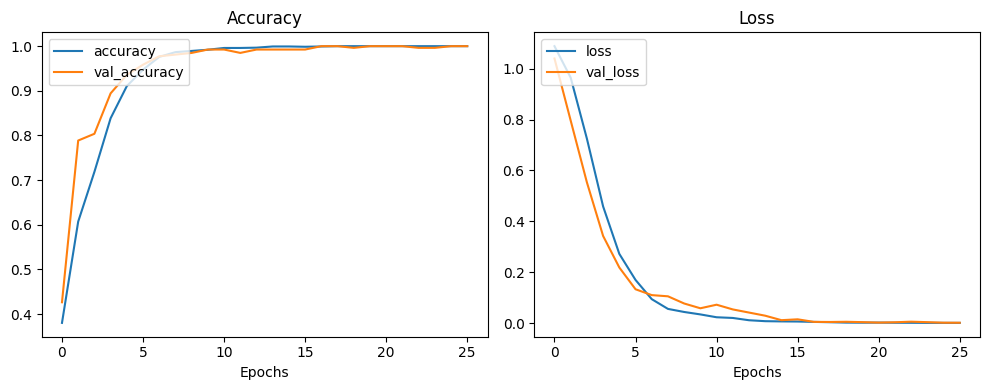

In [ ]:
# Plots the performance of model - Accuracy and Loss

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(result.history['accuracy'], label='accuracy')
ax[0].plot(result.history['val_accuracy'], label='val_accuracy')
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Epochs")

ax[1].plot(result.history['loss'], label='loss')
ax[1].plot(result.history['val_loss'], label='val_loss')
ax[1].legend(loc="upper left")
ax[1].set_title("Loss")
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

The intial model provides a high accuracy, however this uses an arbitrary selection of the architecture and parameters. Additional augmentation during the pre-processing has been added to mitigate the potentially risk of the model overfitting on the training data, and a Random Search is implemented to optimisise the hyperparameters of the model.

The search measures the performance of various models using different number of filters, kernel sizes, and rate for regularisation methods such as Dropout. This could be further improved by additional a selection for the number of layers or the activation function for each layer. The search returns a model with the optimal hyperparameters which can then be compared in performance to the base model trained previously. 

Defines a similar architecture to the previous model, (3 convolutional layers with a final fully connected layer), however this model also applies a data augmentation step to the images after the initial preprocessing.

In [ ]:
# Defines a function that constructs a configurable Convolutional Neural Network (CNN) model 

def build_model(hp):
    model = tf.keras.Sequential([
        preprocessing_Pipeline,
        data_augmentation,
        layers.Conv2D(
            filters = hp.Int('conv_filter_1', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_kernel_1', values=[1, 2, 3, 5]),
            activation='relu',
            input_shape=(IMG_DIM, IMG_DIM, 3)
        ),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters = hp.Int('conv_filter_2', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_kernel_2', values=[1, 2, 3, 5]),
            activation='relu',
            input_shape=(IMG_DIM, IMG_DIM, 3)
        ),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Conv2D(
            filters = hp.Int('conv_filter_3', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_kernel_3', values=[1, 2, 3, 5]),
            activation='relu',
            input_shape=(IMG_DIM, IMG_DIM, 3)
        ),
        layers.MaxPool2D(pool_size=(2, 2)),        
        layers.Flatten(),
        layers.Dense(
            units=hp.Int('dense_units_1', min_value=128, max_value=1024, step=128),
            activation='relu'
        ),
        layers.Dropout(
            rate=hp.Choice('dropout_1', values=[0.2, 0.3, 0.4, 0.5])
        ),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Intialises a random search hyperparameter tuner using the build_model function that aims to optimize the validation accuracy 
# Performs a maximum of 10 trials

hp_tuner = RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='/tmp/tb'
)

In [ ]:
# Adds callback to log each model performance

hp_log = tf.keras.callbacks.TensorBoard(
    log_dir='/tmp/tb_logs'
) 

2023-05-14 13:28:24.157813: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-14 13:28:24.157867: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-14 13:28:24.157919: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [ ]:
# Performs a hyperparameter search and includes callbacks for early stopping and logging hyperparameter search results

hp_tuner.search(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[model_earlyStop, hp_log]
)

Trial 10 Complete [00h 40m 09s]
val_accuracy: 0.9830028414726257

Best val_accuracy So Far: 0.9943342804908752
Total elapsed time: 02h 41m 45s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Returns the best model from search

tuned_model = hp_tuner.get_best_models(num_models=1)[0]

Once the search is completed, the optimal model is returned, and the hyperparameters can be seen below. The hyperparameters and weights for the model returned from the search have been saved in a separate folder due to the significant time taken to run the search, and can be loaded using the cell below. During the search the results of the model compared were logged and can be visualised using TensorBoard, this provided a greater breakdown on the performance on each of the models.

In [ ]:
# Gets the optimal set of parameters found during RandomSearch

hp_tuner.get_best_hyperparameters()[0].values


{'conv_filter_1': 32,
 'conv_kernel_1': 5,
 'conv_filter_2': 32,
 'conv_kernel_2': 1,
 'conv_filter_3': 128,
 'conv_kernel_3': 2,
 'dense_units_1': 1024,
 'dropout_1': 0.3,
 'learning_rate': 0.001}

In [ ]:
# Loads the model architecture

with open('model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
tuned_model = models.model_from_json(loaded_model_json)

# Loads the model weights from the HDF5 file

tuned_model.load_weights("model_weights.h5")


<p align="center">
  <img src="./img/model_2.png"/>
</p>

In [ ]:
# Random Search only fits the model for 20 epochs and further finetunes the model to ensure best accuracy

result = tuned_model.fit(X_train, y_train,
    epochs=20,
    callbacks=[model_earlyStop],
    batch_size=256,
    validation_split=0.15,
    verbose=2
)

Epoch 1/20
6/6 - 25s - loss: 0.2616 - accuracy: 0.9099 - val_loss: 0.1188 - val_accuracy: 0.9547
Epoch 2/20
6/6 - 24s - loss: 0.2854 - accuracy: 0.8939 - val_loss: 0.1025 - val_accuracy: 0.9623
Epoch 3/20
6/6 - 23s - loss: 0.2622 - accuracy: 0.8993 - val_loss: 0.1153 - val_accuracy: 0.9547
Epoch 4/20
6/6 - 23s - loss: 0.2030 - accuracy: 0.9286 - val_loss: 0.0561 - val_accuracy: 0.9849
Epoch 5/20
6/6 - 23s - loss: 0.2029 - accuracy: 0.9333 - val_loss: 0.0639 - val_accuracy: 0.9849
Epoch 6/20
6/6 - 22s - loss: 0.1817 - accuracy: 0.9346 - val_loss: 0.0532 - val_accuracy: 0.9849
Epoch 7/20
6/6 - 22s - loss: 0.2059 - accuracy: 0.9313 - val_loss: 0.0458 - val_accuracy: 0.9887
Epoch 8/20
6/6 - 22s - loss: 0.1777 - accuracy: 0.9520 - val_loss: 0.0449 - val_accuracy: 0.9811
Epoch 9/20
6/6 - 22s - loss: 0.1369 - accuracy: 0.9546 - val_loss: 0.0469 - val_accuracy: 0.9849
Epoch 10/20
6/6 - 22s - loss: 0.1568 - accuracy: 0.9466 - val_loss: 0.0523 - val_accuracy: 0.9849
Epoch 11/20
6/6 - 22s - loss:

In [ ]:
# Gets logs from hp tuning

%load_ext tensorboard

---
## Evaluation

After training, the performance of each of the models is compared using the images in the test set to compare the performance.

Given the high accuracy of the models observed during training, and the similarity between the images, there's a risk that model has been overfit on the training data, and as such will similarly result in a high performance on the test data. To attempt to evaluate this an additonal comparison with an alternative dataset to see if the model returns a similar level of performance compared to the test set.

Test set accuracy: 100.0%


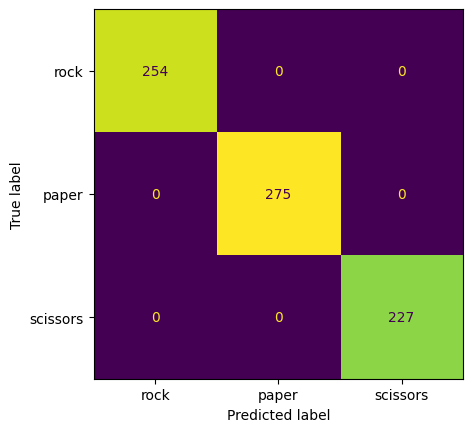

In [ ]:
# Gets performance of base model on test set

predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

print(f"Test set accuracy: {round(accuracy_score(y_test, predictions) * 100, 2)}%")

confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=classes, colorbar=False)
plt.show()

Test set accuracy: 99.6


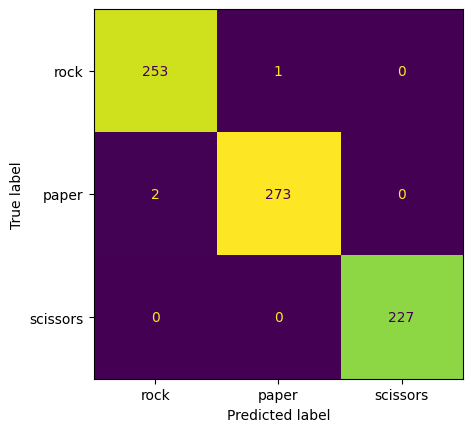

In [ ]:
# Gets performance of tuned model on test set

predictions = tuned_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

print(f"Test set accuracy: {round(accuracy_score(y_test, predictions) * 100, 2)}%")
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=classes, colorbar=False)
plt.show()

### Alternative Dataset Comparison

This measures the performance of the models on unseen data from an alternative Rock, Paper, Scissors dataset.

Dataset available From: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors


In [ ]:
# Loads the images from the specified directory

dataset_dir = './data/rock_paper_scissors/'

sample_generator = ImageDataGenerator()
sample_images = sample_generator.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1,
    shuffle=True,
    seed=0,
)

Found 2188 images belonging to 3 classes.


Accuracy: 0.3336380255941499


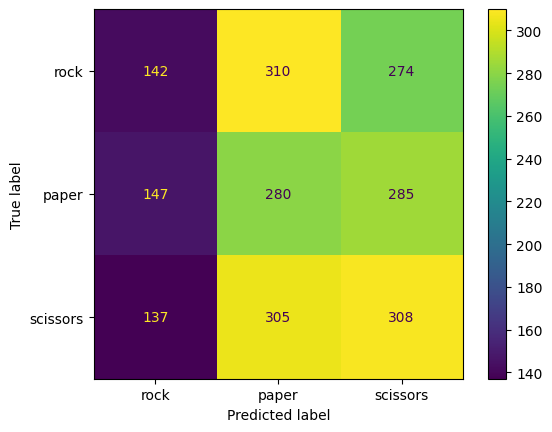

In [ ]:
# Makes predictions using the base model on sample images and displays the accuracy and confusion matrix

sample_predictions = model.predict(sample_images)
sample_predictions = sample_predictions.argmax(axis=-1)

sample_confusion = ConfusionMatrixDisplay.from_predictions(sample_images.labels, sample_predictions, display_labels=classes)
print(f"Accuracy: {accuracy_score(sample_images.labels, sample_predictions)}")

Test set accuracy: 0.3304387568555759


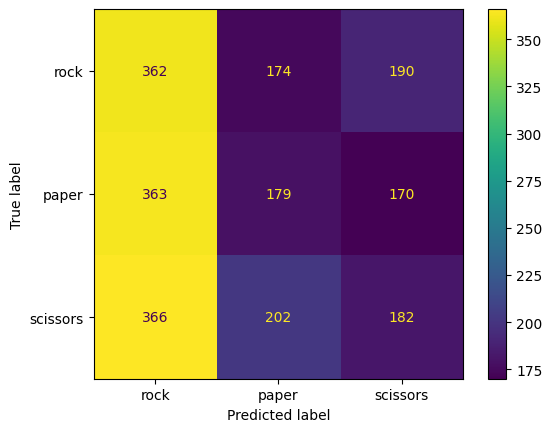

In [ ]:
# Makes predictions using the tuned model on sample images and displays the accuracy and confusion matrix

sample_predictions = tuned_model.predict(sample_images)
sample_predictions = sample_predictions.argmax(axis=-1)

sample_confusion = ConfusionMatrixDisplay.from_predictions(sample_images.labels, sample_predictions, display_labels=classes)
print(f"Test set accuracy: {accuracy_score(sample_images.labels, sample_predictions)}")

### Using a Pre-Trained Model

In [ ]:
# Defines a pre-processing pipeline:-
# Rescaling normalises pixel values within range [0, 1]. To set range [-1, 1] use tf.keras.layers.Rescaling(1./127.5, offset=-1)

vgg_preprocessing = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Resizing(224, 224)
])

vgg_base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224 , 3)
)

# Freezes the base_model

vgg_base_model.trainable = False

In [ ]:
# Constructs a Sequential Model

vgg_model = tf.keras.Sequential()
vgg_model.add(vgg_preprocessing)
vgg_model.add(vgg_base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(3, activation='softmax'))


In [ ]:
# Compiles the VGG model with the necessary parameters

vgg_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vgg_results = vgg_model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[model_earlyStop])


Epoch 1/10
45/45 [==============================] - 72s 2s/step - loss: 0.7439 - accuracy: 0.7585 - val_loss: 0.0151 - val_accuracy: 0.9972
Epoch 2/10
45/45 [==============================] - 74s 2s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 74s 2s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 73s 2s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 73s 2s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 73s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 74s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/10
45/45 [==

First compares the performance of the model on the original dataset to ensure a consistant performance with the other two models

Test set accuracy: 1.0


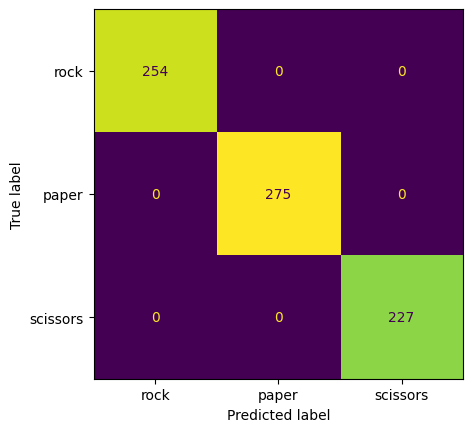

In [ ]:
# Get performance of pre-trained model on original dataset and displays the test set accuracy and confusion matrix
predictions = vgg_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

print(f"Test set accuracy: {accuracy_score(y_test, predictions)}")
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=classes, colorbar=False)
plt.show()

Then finally, compares the performance of the pre-trained model against the alternative dataset.

Test set accuracy: 0.33089579524680074


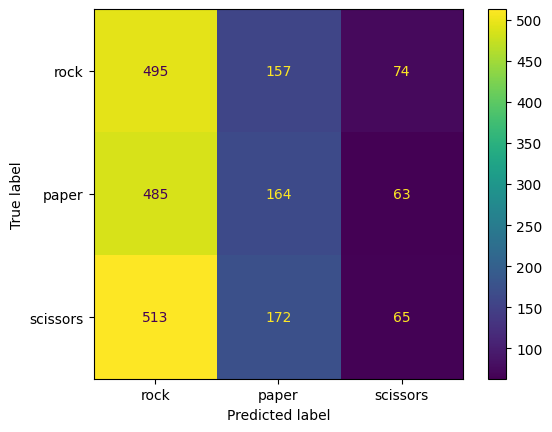

In [ ]:
# Makes predictions using the VGG model on sample images and displays the confusion matrix and accuracy

sample_predictions = vgg_model.predict(sample_images)
sample_predictions = sample_predictions.argmax(axis=-1)

sample_confusion = ConfusionMatrixDisplay.from_predictions(sample_images.labels, sample_predictions, display_labels=classes)
print(f"Test set accuracy: {accuracy_score(sample_images.labels, sample_predictions)}")

In conclusion, the results of the testing show no significant difference in performance between the two models for image classification on the alternative dataset. Whilst the poor quality and increased complexity of the images are likely to have affected the potential accuracy of the models, it is likely that the lack of diversity and size of the initial dataset has limited the information the models were able to extract during training, as such causing the models to overfit and resulting in poor accuracy on unseen data. 

The pre-trained model offered a similar accuracy on the alternative dataset, even with a very simplistic model. As such it is difficult to verify whether the low accuracy is due to the overfitting of the existing models, or as a result of the quality of the images in the second dataset. Additional testing with a more complex model may provide a more clear difference in performance and allow for a more certain conclusion.

Overall the model performance specifically for classifying the dataset provided was extremely accurate, and while tests seem to indicate possible overfitting to the dataset, additional testing with a small sample of self-generated images still provided accurate predictions. For more complex tasks, which requires the classification of images with a greater amount of noise, the models are unlikely to perform well and further training with a larger data set would be required.


---
### Q1 Briefly discuss your selection and application of a programming tool you have used to complete this task, with reference to alternative approaches and justification for why these were not chosen.

<p>
An image classification approach using a Convolutional neural network (CNN) was used accurately to identify images in a dataset to determine whether they were rock, paper or scissors. The implementation involved creating a few different models for comparison on the classification performance.
</p>
<p>
The implementation for each of the models was achieved using TensorFlow and Keras. This allowed the dataset to be loaded directly using a TensorFlow function and passed to additional parts of the model to apply the pre-processing and augmentation to the images in a smooth workflow. A batch size was defined to allow for small segments of the larger dataset to be processed at one time thereby drastically reducing the memory requirements for training the model as not all images needed to be loaded into memory at once. 
</p>
<p>
This also aided tasks such as the hyperparameter tuning as the established pipeline provided an easy method to further update and refine the parameters of the model. For the hyperparameter tuning, a random search was used to measure the performance of models with various hyperparameters and compare the accuracy. During each of the tests the logs were output to a separate file that could be loaded using TensorBoard to view a more detailed analysis of the model training performance. 
</p>
<p>
An alternative approach to this problem that was considered was an object recognition model. However, given similarly between the poses for each class, and the difficulty for these models in correctly identifying the classes of an image, coupled with the higher computation time meant that this approach was not considered for this task. If the task had required the classification of multiple poses within a single image, this approach would have been a much more viable solution to the classification problem.
</p>
<p>
An alternative solution which was considered, and partially implemented, was the use of transfer learning to provide a more generalised solution and mitigate the potential of overfitting on the training data. The performance of a very simplistic model which utilised the pre-trained weights of the VGG16 was compared against both the original and alternative datasets. This model provided a similar accuracy to the other models suggesting that a more comprehensive solution could provide a model that is less likely to overfit. 
</p>

---
### Q2 Compare and contrast an alternative solution to the one you have chosen, including the potential advantages and disadvantages of each.

<p>
An alternative solution to classify the Rock, Paper, Scissors data set is to use an image segmentation model. This approach allows for classification of images on a pixel-by-pixel basis, providing a more detailed evaluation of images compared to the more generalised approach that was used, which evaluates the entire image during classification.
</p>
<p>
Image segmentation involves dividing the images into several segments or regions based on the various characteristics of the image. In this case, using a semantic segmentation model would allow for labels to be assigned to individual pixels which could then be grouped together, providing greater flexibility in highlighting objects within the image.
</p>
<p>
The additional complexity of the model means that it is much more computationally demanding, particularly as the size of the images or dataset increases. Considering the initial outline of the task, the high accuracy of the CNN implemented delivers a much more efficient solution to the task specification. However, when testing the performance of the model on a different dataset the accuracy was poor. For a more generalised solution, the use of image segmentation would provide a better performance on unseen data, as it would allow for clearer evaluation of parts of the image.
</p>
<p>
Another alternative would have been to further optimise the search for the best architecture for the model. Sun et al., 2020 utilises a genetic algorithm to find the optimal architecture to improve classification accuracy. While a random search method used to tune the hyper-parameters performed a similar function, this was limited to tuning factors such as the number of filters, and kernel size rather than the overall structure of the model. While incredibly computationally expensive, utilising this method would allow for the optimisation of the model architecture specific to the classification problem being examined.
</p>
<p>
The justification for a particular model is largely dependent on the task specification. Whilst an alternative method may have produced a more generalised model, the solution developed was an efficient one that provided a high level of accuracy for predictions on the images in the dataset.
</p>

---
### Q3 Select a legal and/or ethical issue that is either directly associated with your solution or relevant to similar problems. Briefly discuss how this issue can be addressed, either in terms of your solution, or other practices within the field.

<p>
When developing an image classification model, it is important to consider the legal or ethical issues that may arise due to the nature of the project or data being used. While the Rock, Paper Scissors dataset did not produce any significant challenges in ensuring the solution developed was ethical, for more complex projects, a lack of consideration of the ethical implications could cause potential harm to the users.
</p>
<p>
For instance, classification tasks which involve more sensitive data, such as for medical diagnosis the requirements for ensuring an ethical solution are much higher. Consideration for the privacy and security of the data supplied to a model must be taken, as it may be possible to infer sensitive information from the images within the dataset. The application of several functions during the collection and pre-processing of the data can be used to remove any identifiable information from the images and techniques such as data augmentation can be used to anonymise the data as well as reduce any potential for bias towards specific groups which may be inferred.
</p>
<p>
Ensuring the necessary permission have been obtained before using data is another important aspect which should be considered. This could mean ensuring that any user provided images are clearly communicated to the user, or by ensuring the use of non-copyrighted materials to train the models. The data used to train the models, in this instance the dataset provided contained only computer-generated images and provided no restrictions on commercial/non-commercial use of the data.
</p>
<p>
The legal and ethical issues must be considered when developing image classification models, so that the appropriate steps can be taken to mitigate any potential risks. While some of these issues don’t apply to this specific task, it is important to consider potential social implications that any solution may cause.
</p>

---
### References

Sun, Y., Xue, B., Zhang, M., Yen, G.G. and Lv, J. (2020) Automatically Designing CNN Architectures Using the Genetic Algorithm for Image Classification. IEEE Transactions on Cybernetics [online]IEEE Transactions on Cybernetics. 50 (9), pp. 3840–3854.

